In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
def load_and_process(url: str, mutation: str) -> pl.DataFrame:
    df = pl.read_parquet(
        url,
        use_pyarrow=True,
    ).group_by(
        ["Task", "Treatment", "Run ID", "Generation Born"],
    ).first().with_columns(
        pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ).alias("Components"),
        pl.lit(mutation).alias("Mutation"),
    )

    return df


In [3]:
df1 = load_and_process("https://osf.io/emh23/download", "poisson")


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [4]:
df2 = load_and_process("https://osf.io/gk2ty/download", "per site")


In [5]:
df = pl.concat([df1, df2])


In [6]:
dfz = df.filter(
    pl.col("has task")
).group_by(
    ["Task", "Treatment", "Run ID", "Components", "Mutation"],
).agg(
    pl.col("Generation Born").min(),
)


In [7]:
maxgen = dfz["Generation Born"].max()

records = []
records2 = set()
for row in dfz.iter_rows(named=True):
    records.append(
        pd.DataFrame(
            {
                "Task": row["Task"],
                "Treatment": row["Treatment"],
                "Run ID": row["Run ID"],
                "Generation": np.arange(maxgen),
                "Components": row["Components"],
                "Has Task":  row["Generation Born"] <= np.arange(maxgen),
                "mutation": row["Mutation"],
            },
        ),
    )
    records2.add(
        (row["Run ID"], row["Treatment"], row["Task"], row["Components"], row["Mutation"]),
    )

for v, grp in df.to_pandas().groupby(
    ["Run ID", "Treatment", "Task", "Components", "Mutation"],
    observed=True,
):
    if v not in records2:
        print(v)
        records.append(
            pd.DataFrame(
                {
                    "Task": v[2],
                    "Treatment": v[1],
                    "Run ID": v[0],
                    "Components": v[3],
                    "Generation": np.arange(maxgen),
                    "Has Task":  False,
                    "mutation": v[4],
                },
            ),
        )

dfz_ = pd.concat(records, ignore_index=True)


('run_1770', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1770', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1770', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1770', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1771', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1771', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1772', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1772', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'NOT', np.int64(1), 'poisson')
('run_1772', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'XOR', np.int64(4), 'poisson'

('run_1823', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1824', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1824', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1825', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1825', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1825', 'Slip-', 'OR', np.int64(3), 'poisson')
('run_1825', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1826', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1826', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1827', 'Slip-', 'AND', np.int64(2), 'poisson')
('run_1827', 'Slip-', 'ANDNOT', np.int64(3), 'poisson')
('run_1827', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1827', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1827', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1828', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1828', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1828', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1829', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1829', 'Slip-', 'NOR

teeplots/col=task+hue=treatment+kind=line+post=plt-xscale-log+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/col=task+hue=treatment+kind=line+post=plt-xscale-log+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


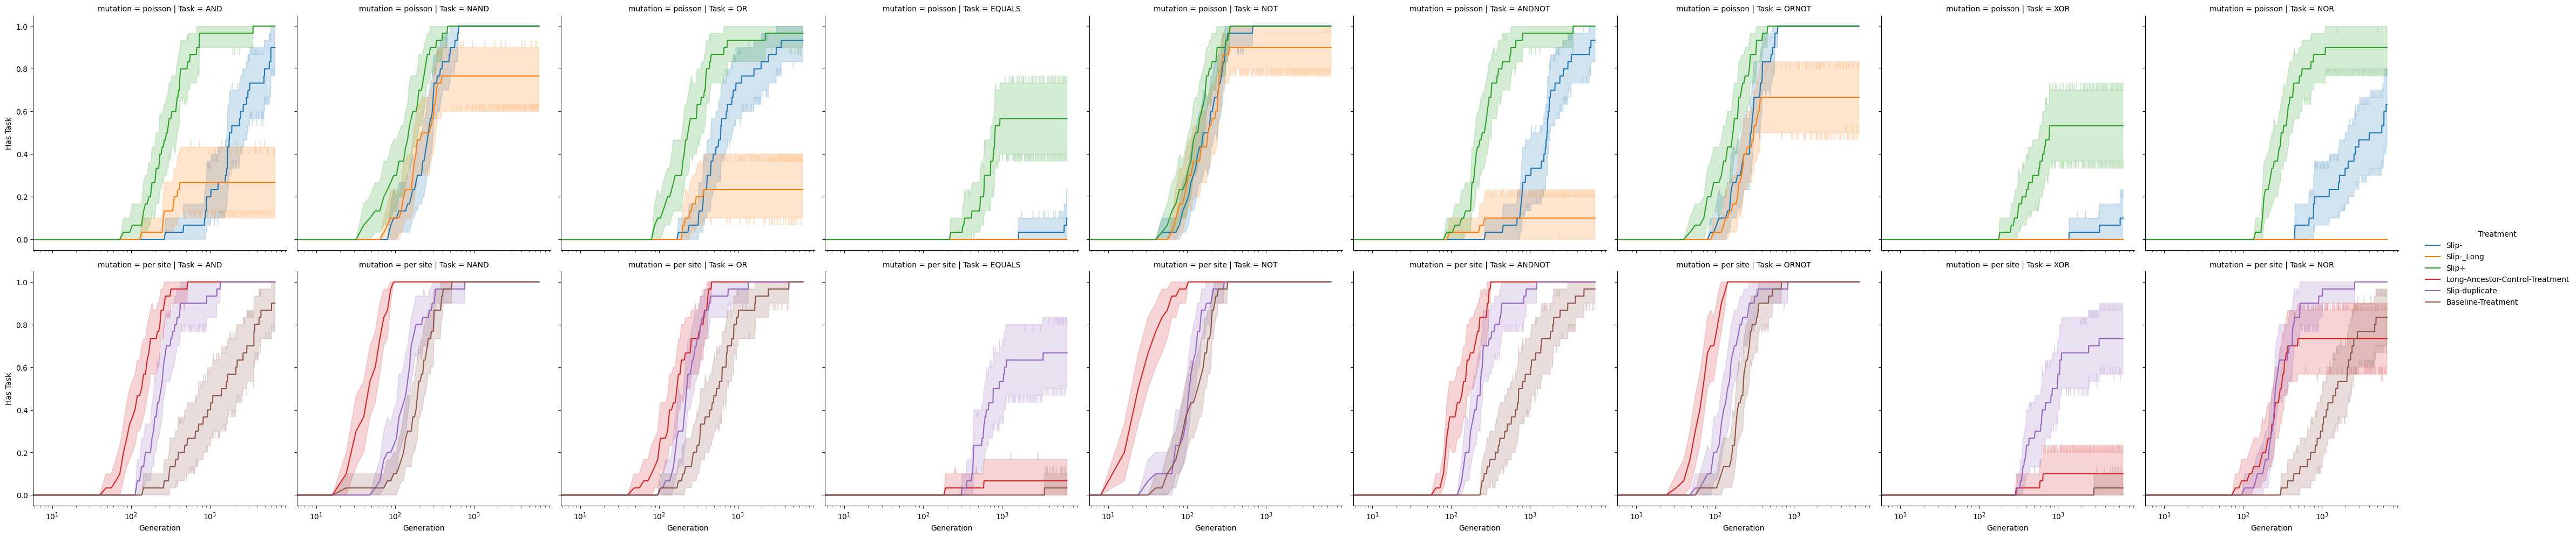

In [8]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 8 == 0
    ].reset_index(),
    col="Task",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    teeplot_postprocess='plt.xscale("log")',
)


teeplots/col=components+hue=treatment+kind=line+post=plt-xscale-log+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/col=components+hue=treatment+kind=line+post=plt-xscale-log+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


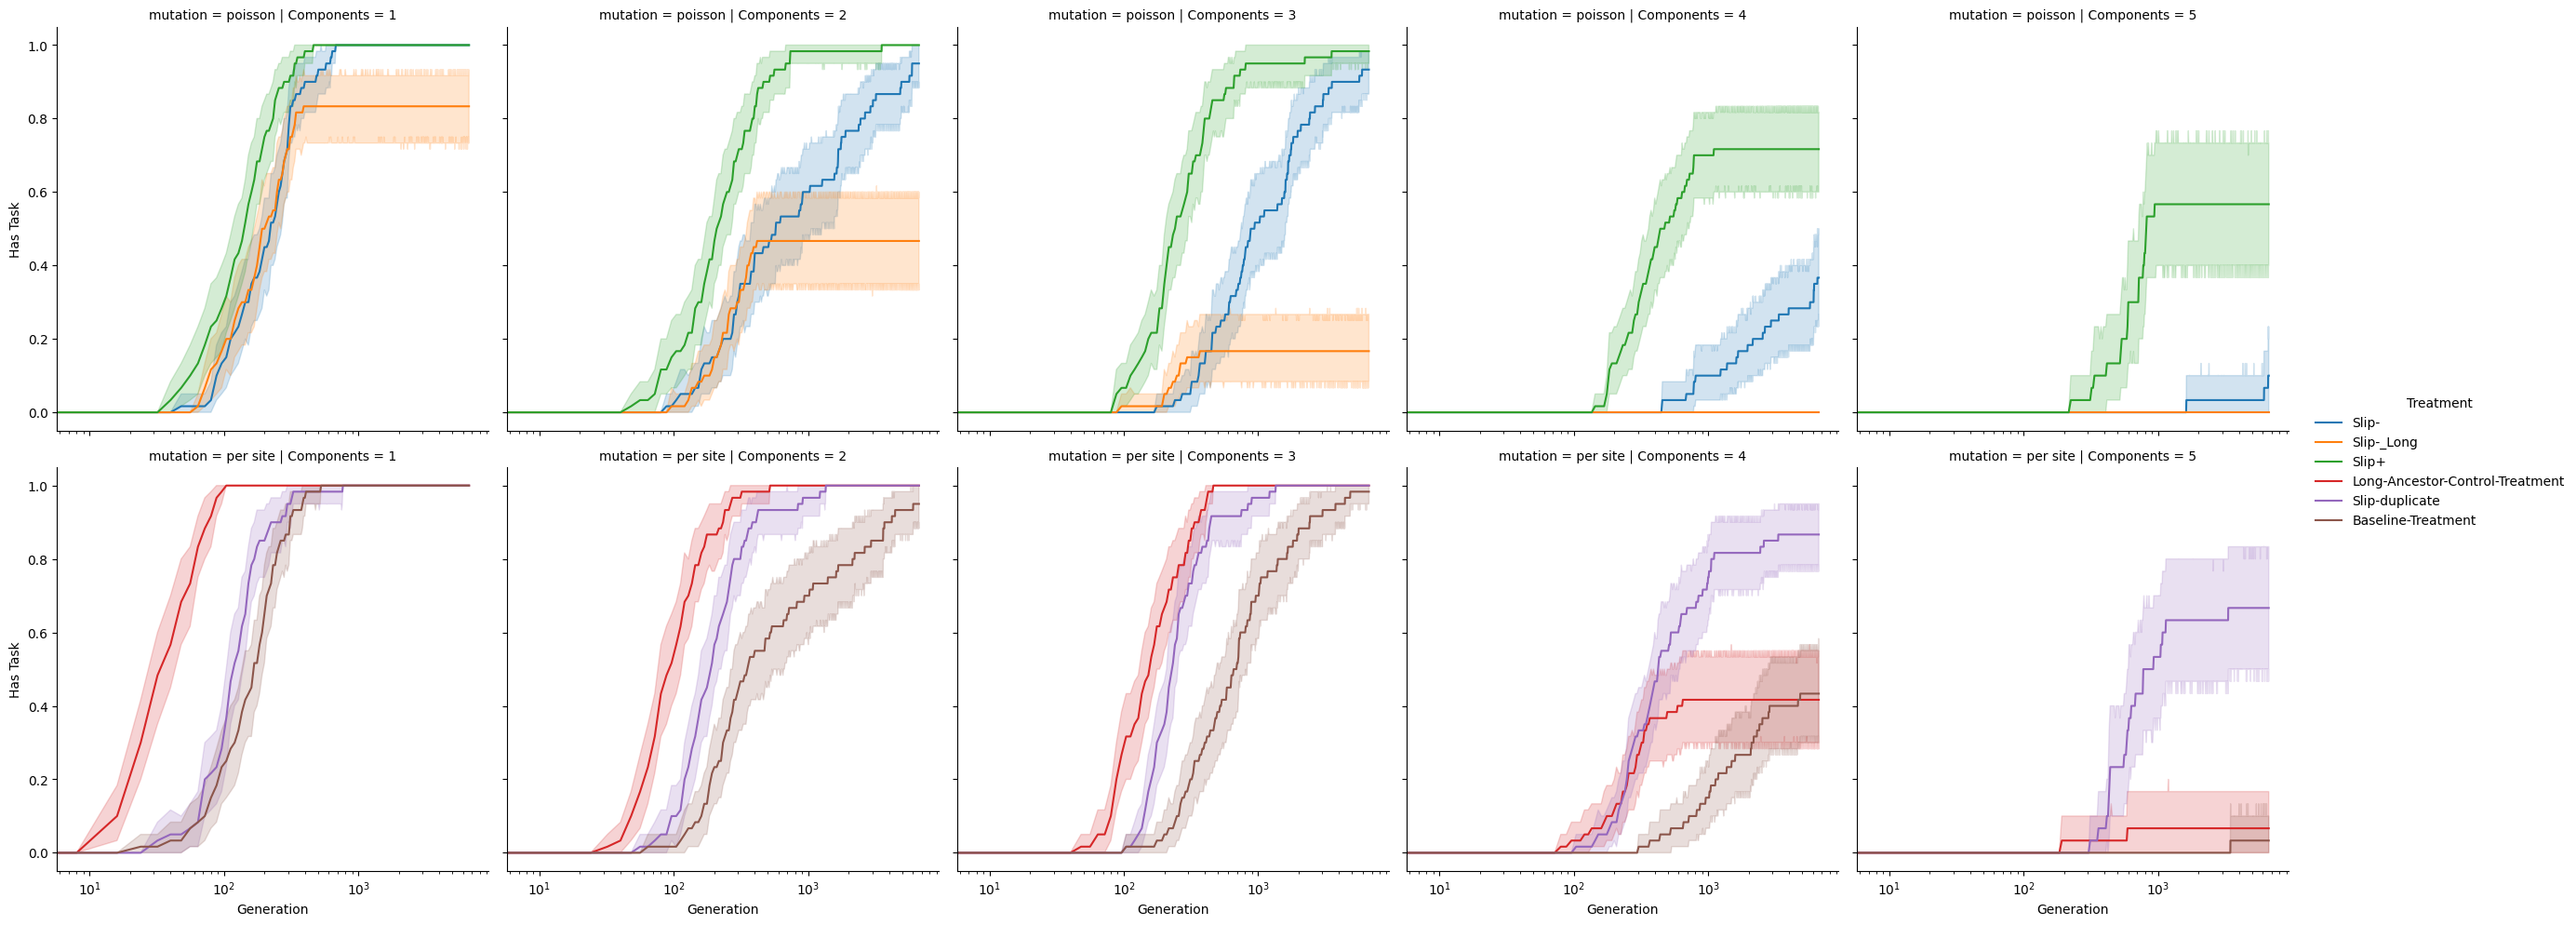

In [9]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 8 == 0
    ].reset_index(),
    col="Components",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    teeplot_postprocess='plt.xscale("log")',
)
